# 基于TimesFM预训练模型的投资组合优化

本教程演示如何使用Google Research的TimesFM预训练模型来进行投资组合优化。TimesFM是一个在大规模金融时间序列数据上进行预训练的模型，可能会带来比传统深度学习模型更好的性能。

## 本教程包括：

1. 数据准备和预处理
2. TimesFM模型设置和配置
3. 模型训练和优化过程
4. 性能评估和可视化分析

In [1]:
# 添加项目根目录到Python路径
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

# 导入必要的库
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timesfm
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 设置随机种子以保证可重复性
torch.manual_seed(42)
np.random.seed(42)

# 设置绘图样式
plt.style.use('default')  # 使用默认样式
sns.set_style("whitegrid")  # 使用seaborn的网格样式

# 设置中文字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 尝试设置中文字体，如果可用的话
try:
    import matplotlib.font_manager as fm
    # 检查是否有中文字体可用
    chinese_fonts = [f.name for f in fm.fontManager.ttflist if 'Hei' in f.name or 'Kai' in f.name or 'Song' in f.name]
    if chinese_fonts:
        plt.rcParams['font.sans-serif'].insert(0, chinese_fonts[0])
        print(f"使用中文字体: {chinese_fonts[0]}")
    else:
        print("未找到中文字体，使用默认英文字体")
except Exception as e:
    print(f"字体配置警告: {e}")
    print("使用默认字体设置")

# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用中文字体: WenQuanYi Zen Hei
使用设备: cuda


## 数据准备和预处理

首先，我们需要加载和处理金融数据。我们使用Magnificent 7（AAPL、AMZN、GOOGL、META、MSFT、NVDA、TSLA）的每日收盘价数据，并计算对数回报率用于模型训练。

In [2]:
# 加载原始数据
# 添加快速测试模式，通过设置test_mode=True并指定test_data_size来减少数据量
test_mode = False  # 设置为True以启用快速测试模式
test_data_size = 600  # 在测试模式下使用的数据行数

data_raw = pd.read_parquet('../data/mag7_data_raw.parquet')

if test_mode and test_data_size < len(data_raw):
    print(f"注意：正在测试模式下运行，仅使用前 {test_data_size} 行数据")
    data_raw = data_raw.iloc[:test_data_size]

print("数据形状:", data_raw.shape)
print("数据列名:", data_raw.columns.tolist()[:10], "...")  # 只显示前10个列名
print("\n前5行数据:")
display(data_raw.head())

# 提取Close价格用于计算回报率（目标变量）
close_prices = data_raw['Close']  # 提取Close列的所有股票
returns = np.log(close_prices / close_prices.shift(1))

# 处理NaN值
returns.iloc[0] = 0  # 第一天的回报率设为0
returns = returns.ffill()  # 用前一个有效值填充其他NaN
returns = returns.bfill()  # 如果数据开头有NaN，用后一个有效值填充

print("\n回报率数据形状:", returns.shape)
print("\n回报率统计描述:")
display(returns.describe())

# 准备输入特征数据：用户可配置特征选择
# 用户可以修改下面的列表来选择想要使用的特征
AVAILABLE_FEATURES = ['Close', 'High', 'Low', 'Open', 'Volume']  # 所有可用特征
SELECTED_FEATURES = ['Close']  # 用户选择的特征

# 验证选择的特征是否有效
invalid_features = [f for f in SELECTED_FEATURES if f not in AVAILABLE_FEATURES]
if invalid_features:
    raise ValueError(f"无效的特征: {invalid_features}. 可用特征: {AVAILABLE_FEATURES}")

print(f"可用特征: {AVAILABLE_FEATURES}")
print(f"选择的特征: {SELECTED_FEATURES}")
print(f"特征数量: {len(SELECTED_FEATURES)}")

# 重新组织数据为 (时间步, 股票, 特征) 的格式
tickers = close_prices.columns.tolist()  # 股票列表
features = SELECTED_FEATURES  # 使用用户选择的特征

# 创建特征矩阵
n_timesteps = len(data_raw)
n_stocks = len(tickers)
n_features = len(features)

features_data = np.zeros((n_timesteps, n_stocks, n_features))

for i, ticker in enumerate(tickers):
    for j, feature in enumerate(features):
        features_data[:, i, j] = data_raw[feature][ticker].ffill().fillna(0)

print(f"\n特征数据形状: {features_data.shape} (时间步, 股票数, 特征数)")
print(f"股票列表: {tickers}")
print(f"使用的特征: {features}")

# 显示特征数据的统计信息
print(f"\n各特征的统计描述:")
for i, feature in enumerate(features):
    feature_data = features_data[:, :, i]
    print(f"\n{feature}:")
    print(f"  均值: {np.mean(feature_data):.4f}")
    print(f"  标准差: {np.std(feature_data):.4f}")
    print(f"  最小值: {np.min(feature_data):.4f}")
    print(f"  最大值: {np.max(feature_data):.4f}")

数据形状: (5027, 35)
数据列名: [('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'GOOGL'), ('Close', 'META'), ('Close', 'MSFT'), ('Close', 'NVDA'), ('Close', 'TSLA'), ('High', 'AAPL'), ('High', 'AMZN'), ('High', 'GOOGL')] ...

前5行数据:


Price          Close                                                   \
Ticker          AAPL    AMZN     GOOGL META       MSFT      NVDA TSLA   
Date                                                                    
2005-09-26  1.616283  2.1670  7.810992  NaN  17.601694  0.251990  NaN   
2005-09-27  1.604275  2.1580  7.802541  NaN  17.650463  0.252831  NaN   
2005-09-28  1.533428  2.1685  7.605204  NaN  17.880327  0.254360  NaN   
2005-09-29  1.571253  2.2395  7.695174  NaN  18.068390  0.259632  NaN   
2005-09-30  1.609379  2.2650  7.865171  NaN  17.922119  0.261924  NaN   

Price           High                    ...       Open                 \
Ticker          AAPL    AMZN     GOOGL  ...       MSFT      NVDA TSLA   
Date                                    ...                             
2005-09-26  1.637897  2.1710  7.976766  ...  17.692244  0.251838  NaN   
2005-09-27  1.628291  2.1865  7.913637  ...  17.671360  0.253060  NaN   
2005-09-28  1.594369  2.1870  7.831371  ...  17.685294  0.253595  NaN   
2005-09-29  1.578758  2.2400  7.722513  ...  17.838530  0.254436  NaN   
2005-09-30  1.610579  2.2920  7.891019  ...  18.047498  0.259784  NaN   

Price           Volume                                                       
Ticker            AAPL       AMZN      GOOGL META      MSFT       NVDA TSLA  
Date                                                                         
2005-09-26   546562800  112328000  395380224  NaN  56203700  406776000  NaN  
2005-09-27   341703600   83470000  274649076  NaN  48797900  404160000  NaN  
2005-09-28  1125544000   64794000  319576104  NaN  71019400  353556000  NaN  
2005-09-29   636846000  127856000  224327448  NaN  66807100  513372000  NaN  
2005-09-30   531633200  121120000  365685948  NaN  57644500  458832000  NaN  

[5 rows x 35 columns]


回报率数据形状: (5027, 7)

回报率统计描述:


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
count,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000
mean,0.000993,0.000929,0.000691,0.000601,0.000669,0.001303,0.001107
std,0.020171,0.023704,0.018871,0.020506,0.017262,0.030977,0.031735
min,-0.197470,-0.246182,-0.123685,-0.306391,-0.159453,-0.367109,-0.236518
25%,-0.008299,-0.009947,-0.007992,-0.003911,-0.007260,-0.013709,-0.009642
50%,0.001000,0.000707,0.000790,0.000000,0.000588,0.001625,0.000000
75%,0.011389,0.012336,0.009885,0.005970,0.009117,0.016843,0.012933
max,0.142617,0.238621,0.182251,0.259371,0.170626,0.260876,0.218292


可用特征: ['Close', 'High', 'Low', 'Open', 'Volume']
选择的特征: ['Close']
特征数量: 1

特征数据形状: (5027, 7, 1) (时间步, 股票数, 特征数)
股票列表: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
使用的特征: ['Close']

各特征的统计描述:

Close:
  均值: 74.1321
  标准差: 108.0494
  最小值: 0.0000
  最大值: 790.0000


In [3]:
# 特征选择配置
# 用户可以从以下预设配置中选择，或自定义特征组合

# 预设配置1：仅价格特征
PRICE_ONLY = ['Close', 'High', 'Low', 'Open']

# 预设配置2：价格+成交量
PRICE_AND_VOLUME = ['Close', 'High', 'Low', 'Open', 'Volume']

# 预设配置3：仅收盘价
CLOSE_ONLY = ['Close']

# 预设配置4：高低收盘价
OHLC = ['Open', 'High', 'Low', 'Close']

# 预设配置5：收盘价+成交量
CLOSE_AND_VOLUME = ['Close', 'Volume']

# 用户可以选择以下配置之一，或者自定义
FEATURE_CONFIGS = {
    'price_only': PRICE_ONLY,
    'price_and_volume': PRICE_AND_VOLUME, 
    'close_only': CLOSE_ONLY,
    'ohlc': OHLC,
    'close_and_volume': CLOSE_AND_VOLUME
}

print("可用的特征配置:")
for config_name, features in FEATURE_CONFIGS.items():
    print(f"  {config_name}: {features}")

print("\n使用方法:")
print("1. 选择预设配置：SELECTED_FEATURES = FEATURE_CONFIGS['price_only']")
print("2. 自定义配置：SELECTED_FEATURES = ['Close', 'High', 'Volume']")
print("3. 使用所有特征：SELECTED_FEATURES = ['Close', 'High', 'Low', 'Open', 'Volume']")

可用的特征配置:
  price_only: ['Close', 'High', 'Low', 'Open']
  price_and_volume: ['Close', 'High', 'Low', 'Open', 'Volume']
  close_only: ['Close']
  ohlc: ['Open', 'High', 'Low', 'Close']
  close_and_volume: ['Close', 'Volume']

使用方法:
1. 选择预设配置：SELECTED_FEATURES = FEATURE_CONFIGS['price_only']
2. 自定义配置：SELECTED_FEATURES = ['Close', 'High', 'Volume']
3. 使用所有特征：SELECTED_FEATURES = ['Close', 'High', 'Low', 'Open', 'Volume']


In [4]:
# 创建训练数据序列
def create_sequences_3d(features_data, returns_data, window_size=20):
    """
    为3D特征数据和2D回报率数据创建序列

    Args:
        features_data: 形状为 (n_timesteps, n_stocks, n_features) 的特征数据
        returns_data: 形状为 (n_timesteps, n_stocks) 的回报率数据
        window_size: 时间窗口大小

    Returns:
        X: 输入特征序列，形状为 (n_samples, window_size, n_stocks, n_features)
        y: 目标回报率序列，形状为 (n_samples, n_stocks)
    """
    sequences = []
    targets = []

    n_timesteps = features_data.shape[0]

    for i in range(n_timesteps - window_size):
        # 输入序列：过去window_size天的所有特征
        sequence = features_data[i:i+window_size]  # 形状: (window_size, n_stocks, n_features)
        # 目标：下一天的回报率
        target = returns_data.iloc[i+window_size].values  # 形状: (n_stocks,)

        sequences.append(sequence)
        targets.append(target)

    return np.array(sequences), np.array(targets)

# 创建训练数据
window_size = 20
X, y = create_sequences_3d(features_data, returns, window_size)
print("输入数据形状:", X.shape)  # (样本数, 时间步长, 股票数, 特征数)
print("目标数据形状:", y.shape)  # (样本数, 股票数)

# 将数据转换为PyTorch张量
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# 分割数据集
train_val_size = int(0.8 * len(X))
train_size = int(0.8 * train_val_size)
X_test = X_tensor[train_val_size:]
y_test = y_tensor[train_val_size:]
X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]
X_val = X_tensor[train_size:train_val_size]
y_val = y_tensor[train_size:train_val_size]

# 将数据移至GPU（如果可用）
if torch.cuda.is_available():
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_val = X_val.cuda()
    y_val = y_val.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

# 创建数据加载器
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("\n数据集大小:")
print(f"训练集: {len(X_train)} 样本 ({len(X_train)/len(X_tensor):.1%})")
print(f"验证集: {len(X_val)} 样本 ({len(X_val)/len(X_tensor):.1%})")
print(f"测试集: {len(X_test)} 样本 ({len(X_test)/len(X_tensor):.1%})")

输入数据形状: (5007, 20, 7, 1)
目标数据形状: (5007, 7)

数据集大小:
训练集: 3204 样本 (64.0%)
验证集: 801 样本 (16.0%)
测试集: 1002 样本 (20.0%)


In [5]:
#从train_loader中读取一个batch的数据
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)  # (batch_size, window_size, num_stocks, num_features)
    print("Batch y shape:", batch_y.shape)  # (batch_size, num_stocks)
    print("特征维度:", batch_X.shape[3], "包含:", ['Close', 'High', 'Low', 'Open', 'Volume'])
    break  # 只查看第一个batch

Batch X shape: torch.Size([128, 20, 7, 1])
Batch y shape: torch.Size([128, 7])
特征维度: 1 包含: ['Close', 'High', 'Low', 'Open', 'Volume']


## TimesFM模型设置

我们使用Google Research的TimesFM预训练模型作为特征提取器，并在其基础上构建一个投资组合优化模型。模型架构包含以下几个部分：

1. TimesFM预训练模型作为特征提取器
2. 投资组合优化头部网络
3. Softmax层确保权重和为1且非负

In [6]:
# 创建TimesFM模型
timesfm_model = timesfm.TimesFM_2p5_200M_torch()

# 配置并编译模型
print("编译TimesFM模型...")
forecast_config =  timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=256,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
        per_core_batch_size=96
    )

timesfm_model.compile(forecast_config=forecast_config)
print("TimesFM模型编译完成！")

# 创建投资组合优化模型
class TimesFMPortfolioModel(nn.Module):
    def __init__(self, input_size, output_size, feature_size, timesfm_model: timesfm.TimesFM_2p5_200M_torch, context_len, finetune_timesfm=False):
        super(TimesFMPortfolioModel, self).__init__()
        self.timesfm = timesfm_model
        self.timesfm_model = timesfm_model.model
        self.context_len = context_len
        self.feature_size = feature_size
        self.finetune_timesfm = finetune_timesfm
        
        # 根据参数决定是否冻结TimesFM的参数
        if not finetune_timesfm:
            # 冻结TimesFM的参数
            for param in self.timesfm.model.parameters():
                param.requires_grad = False
            print("TimesFM参数已冻结，仅训练投资组合优化层")
        else:
            # 启用TimesFM参数的梯度
            for param in self.timesfm.model.parameters():
                param.requires_grad = True
            print("TimesFM参数已解冻，将进行端到端微调")
            
        # 特征处理层：将每个股票的多个特征整合
        self.feature_processor = nn.Sequential(
            nn.Linear(feature_size, 32),  # 将5个特征压缩到32维
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # 投资组合优化头部网络
        # 输入是每个资产的预测收益率，所以维度是 input_size
        self.portfolio_head = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, output_size)
        )
        
        # Softmax层确保权重和为1且非负
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x的形状: (batch_size, context_len, num_assets, num_features)
        batch_size, _, num_assets, num_features = x.shape
        
        # 我们想要预测未来1期的收益
        forecast_horizon = 1
        
        # 处理每个资产的特征
        processed_features = []
        for i in range(num_assets):
            # 提取第i只股票的所有特征: (batch_size, context_len, num_features)
            asset_features = x[:, :, i, :]
            
            # 对每个时间步的特征进行处理
            # 先reshape为 (batch_size * context_len, num_features)
            asset_features_flat = asset_features.view(-1, num_features)
            
            # 通过特征处理器
            processed = self.feature_processor(asset_features_flat)  # (batch_size * context_len, 32)
            
            # 重新reshape回 (batch_size, context_len, 32)
            processed = processed.view(batch_size, self.context_len, -1)
            
            processed_features.append(processed)
        
        # 将所有资产的处理后特征堆叠: (batch_size, context_len, num_assets, 32)
        combined_features = torch.stack(processed_features, dim=2)
        
        # 为TimesFM准备输入：需要将每个资产的序列分别输入
        all_series = []
        for i in range(num_assets):
            for j in range(batch_size):
                # 提取单个资产的处理后特征序列: (context_len, 32)
                asset_series = combined_features[j, :, i, :]
                # 将多维特征展平或聚合为1D序列用于TimesFM
                # 这里我们简单地取平均值作为该资产的代表性序列
                asset_series_1d = torch.mean(asset_series, dim=1)  # (context_len,)
                all_series.append(asset_series_1d.detach().cpu().numpy())
        
        # 批量调用TimesFM进行预测
        # all_series 包含 batch_size * num_assets 个序列
        point_forecasts, _ = self.timesfm.forecast(
            horizon=forecast_horizon,
            inputs=all_series
        )
        
        # point_forecasts 形状: (batch_size * num_assets, forecast_horizon)
        # 我们只需要第一个预测值，所以形状变为 (batch_size * num_assets,)
        point_forecasts = point_forecasts[:, 0]
        
        # 重新组织预测结果：从 (batch_size * num_assets,) 变为 (batch_size, num_assets)
        combined_forecasts = point_forecasts.reshape(batch_size, num_assets)
        
        # 转换为PyTorch张量并移动到正确的设备
        combined_forecasts = torch.from_numpy(combined_forecasts).float().to(x.device)
        
        # 通过头部网络得到权重
        # 注意：这里我们使用预测结果作为输入，而不是原始特征
        weights = self.portfolio_head(combined_forecasts)
        
        # 应用Softmax得到最终的投资组合权重
        weights = self.softmax(weights)
        
        return weights

# 初始化模型
input_size = X.shape[2]  # 股票数量
feature_size = X.shape[3]  # 每只股票的特征数量 (5: Close, High, Low, Open, Volume)
output_size = input_size  # 输出权重的维度与股票数量相同

# 设置是否微调TimesFM模型
finetune_timesfm = True  # 改为True启用TimesFM参数微调，False则仅训练投资组合层

timesfm_portfolio_model = TimesFMPortfolioModel(
    input_size, 
    output_size, 
    feature_size, 
    timesfm_model, 
    window_size, 
    finetune_timesfm=finetune_timesfm
).to(device)

print(f"模型总参数数量: {sum(p.numel() for p in timesfm_portfolio_model.parameters()):,}")
print(f"可训练参数数量: {sum(p.numel() for p in timesfm_portfolio_model.parameters() if p.requires_grad):,}")
print(timesfm_portfolio_model)

# 定义投资组合损失函数
def portfolio_loss(weights, returns, risk_aversion=1.0):
    # 计算投资组合收益
    portfolio_return = torch.sum(weights * returns, dim=1)
    
    # 计算平均收益
    expected_return = torch.mean(portfolio_return)
    
    # 计算风险（使用样本标准差的平方而不是方差）
    epsilon = 1e-8
    portfolio_risk = torch.mean((portfolio_return - expected_return) ** 2) + epsilon
    
    # 风险调整后的收益（负号是因为我们要最大化收益，而优化器是最小化损失）
    loss = -(expected_return - risk_aversion * portfolio_risk)
    
    # 添加正则化项以防止权重过于集中
    weight_regularization = torch.mean(torch.sum(weights ** 2, dim=1))
    regularization_factor = 0.01
    loss = loss + regularization_factor * weight_regularization
    
    return loss

# 定义优化器和学习率
risk_aversion = 5.0  # 风险厌恶系数

# 根据是否微调TimesFM设置不同的学习率策略
if finetune_timesfm:
    # 对TimesFM使用较小的学习率，对投资组合层使用较大的学习率
    timesfm_params = []
    portfolio_params = []
    
    # 分离TimesFM参数和投资组合层参数
    for name, param in timesfm_portfolio_model.named_parameters():
        if 'timesfm' in name:
            timesfm_params.append(param)
        else:
            portfolio_params.append(param)
    
    # 使用不同学习率的参数组
    optimizer = torch.optim.Adam([
        {'params': timesfm_params, 'lr': 1e-5, 'name': 'timesfm'},  # TimesFM使用较小学习率
        {'params': portfolio_params, 'lr': 1e-3, 'name': 'portfolio'}  # 投资组合层使用较大学习率
    ])
    
    print(f"微调模式：TimesFM参数数量: {sum(p.numel() for p in timesfm_params):,}")
    print(f"微调模式：投资组合层参数数量: {sum(p.numel() for p in portfolio_params):,}")
    print("使用分层学习率：TimesFM lr=1e-5, 投资组合层 lr=1e-3")
    
else:
    # 仅训练投资组合层时使用标准学习率
    optimizer = torch.optim.Adam(timesfm_portfolio_model.parameters(), lr=0.0001)
    print("仅训练投资组合层，使用学习率 lr=1e-4")

编译TimesFM模型...
TimesFM模型编译完成！
TimesFM参数已解冻，将进行端到端微调
模型总参数数量: 231,297,031
可训练参数数量: 231,297,031
TimesFMPortfolioModel(
  (timesfm_model): TimesFM_2p5_200M_torch_module(
    (tokenizer): ResidualBlock(
      (hidden_layer): Linear(in_features=64, out_features=1280, bias=True)
      (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
      (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
      (activation): SiLU()
    )
    (stacked_xf): ModuleList(
      (0-19): 20 x Transformer(
        (pre_attn_ln): RMSNorm()
        (post_attn_ln): RMSNorm()
        (attn): MultiHeadAttention(
          (query): Linear(in_features=1280, out_features=1280, bias=False)
          (key): Linear(in_features=1280, out_features=1280, bias=False)
          (value): Linear(in_features=1280, out_features=1280, bias=False)
          (out): Linear(in_features=1280, out_features=1280, bias=False)
          (query_ln): RMSNorm()
          (key_ln): RMSNorm()
          (rotar

In [7]:
# 显示训练配置信息
print("=" * 80)
print("训练配置信息")
print("=" * 80)
print(f"选择的特征: {SELECTED_FEATURES}")
print(f"特征数量: {len(SELECTED_FEATURES)}")
print(f"微调TimesFM: {'是' if finetune_timesfm else '否'}")
print(f"训练轮数: {20 if finetune_timesfm else 15}")
print(f"早停耐心: {20 if finetune_timesfm else 15}")
print(f"梯度裁剪阈值: {1.0 if finetune_timesfm else 5.0}")
print(f"风险厌恶系数: {risk_aversion}")

if finetune_timesfm:
    print("\n微调策略:")
    print("- TimesFM参数学习率: 1e-5")
    print("- 投资组合层学习率: 1e-3") 
    print("- 使用学习率调度器")
    print("- 应用梯度裁剪")
else:
    print("\n仅训练投资组合层:")
    print("- 投资组合层学习率: 1e-4")
    print("- TimesFM参数冻结")

print("=" * 80)

训练配置信息
选择的特征: ['Close']
特征数量: 1
微调TimesFM: 是
训练轮数: 20
早停耐心: 20
梯度裁剪阈值: 1.0
风险厌恶系数: 5.0

微调策略:
- TimesFM参数学习率: 1e-5
- 投资组合层学习率: 1e-3
- 使用学习率调度器
- 应用梯度裁剪


In [8]:
# 训练模型
import os
from datetime import datetime

# 创建模型保存目录
model_save_dir = '../models'
os.makedirs(model_save_dir, exist_ok=True)

# 生成带时间戳的模型文件名
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
best_model_path = os.path.join(model_save_dir, f'timesfm_portfolio_model_best_{timestamp}.pth')
final_model_path = os.path.join(model_save_dir, f'timesfm_portfolio_model_final_{timestamp}.pth')

# 添加学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

num_epochs = 20 if finetune_timesfm else 15  # 微调时使用更多epoch
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 20 if finetune_timesfm else 15  # 微调时使用更多耐心
patience_counter = 0

# 梯度裁剪阈值
grad_clip_value = 1.0 if finetune_timesfm else 5.0

print(f"开始在 {device} 上训练模型...")
print(f"训练集大小: {len(train_loader.dataset)}, 验证集大小: {len(val_loader.dataset)}, 测试集大小: {len(test_loader.dataset)}")
print(f"批次大小: {train_loader.batch_size}, 训练批次数量: {len(train_loader)}, 验证批次数量: {len(val_loader)}")
print(f"模型保存路径: {model_save_dir}")
print("=" * 80)

for epoch in range(num_epochs):
    # 训练阶段
    timesfm_portfolio_model.train()
    epoch_train_loss = 0
    train_batches = 0
    
    i = 0
    for batch_X, batch_y in train_loader:
        # 确保数据在正确的设备上
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        
        weights = timesfm_portfolio_model(batch_X)
        loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
        loss.backward()
        
        # 梯度裁剪以稳定训练
        if finetune_timesfm:
            torch.nn.utils.clip_grad_norm_(timesfm_portfolio_model.parameters(), grad_clip_value)
        
        optimizer.step()
        epoch_train_loss += loss.item()
        train_batches += 1
        
        
        i = i + 1

    
    epoch_train_loss /= train_batches
    train_losses.append(epoch_train_loss)
    
    # 验证阶段
    timesfm_portfolio_model.eval()
    epoch_val_loss = 0
    val_batches = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            weights = timesfm_portfolio_model(batch_X)
            loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
            epoch_val_loss += loss.item()
            val_batches += 1
    
    epoch_val_loss /= val_batches
    val_losses.append(epoch_val_loss)
    
    # 更新学习率调度器
    scheduler.step(epoch_val_loss)
    
    # 获取当前学习率用于显示
    current_lrs = [group['lr'] for group in optimizer.param_groups]
    lr_info = f"LR: {current_lrs}" if len(current_lrs) > 1 else f"LR: {current_lrs[0]:.2e}"
    
    # 计算改进情况
    improvement = (best_val_loss - epoch_val_loss) if epoch > 0 else 0
    
    # 早停检查
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = timesfm_portfolio_model.state_dict().copy()
        
        # 保存最佳模型
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': best_val_loss,
            'train_loss': epoch_train_loss,
            'risk_aversion': risk_aversion,
            'input_size': input_size,
            'feature_size': feature_size,
            'window_size': window_size,
            'finetune_timesfm': finetune_timesfm,
            'timestamp': timestamp
        }, best_model_path)
        
        patience_counter = 0
        status = f"模型已更新并保存到 {best_model_path}"
    else:
        patience_counter += 1
        status = f"耐心计数: {patience_counter}/{patience}"
        
    if patience_counter >= patience:
        print(f'早停: 验证损失在 {patience} 个epoch内没有改善')
        break
    
    # 打印详细信息
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1:2d}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:8.4f}, '
              f'Val Loss: {epoch_val_loss:8.4f}, '
              f'Improvement: {improvement:8.4f}, '
              f'{lr_info}, '
              f'{status}')
    elif improvement > 0.001:  # 当有显著改进时也打印
        print(f'Epoch [{epoch+1:2d}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:8.4f}, '
              f'Val Loss: {epoch_val_loss:8.4f}, '
              f'Improvement: {improvement:8.4f}, '
              f'{lr_info}, '
              f'{status}')

# 加载最佳模型状态
if best_model_state is not None:
    timesfm_portfolio_model.load_state_dict(best_model_state)
    print(f'\n已恢复最佳模型（验证损失: {best_val_loss:.4f}）')
else:
    print('\n未找到改进的模型状态')

# 保存最终模型
final_model_state = timesfm_portfolio_model.state_dict()
torch.save({
    'epoch': len(train_losses),
    'model_state_dict': final_model_state,
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'final_train_loss': train_losses[-1] if train_losses else None,
    'final_val_loss': val_losses[-1] if val_losses else None,
    'best_val_loss': best_val_loss,
    'risk_aversion': risk_aversion,
    'input_size': input_size,
    'feature_size': feature_size,
    'window_size': window_size,
    'finetune_timesfm': finetune_timesfm,
    'timestamp': timestamp,
    'training_completed': True
}, final_model_path)

print(f"最终模型已保存到: {final_model_path}")
print("=" * 80)
print("训练完成!")

开始在 cuda 上训练模型...
训练集大小: 3204, 验证集大小: 801, 测试集大小: 1002
批次大小: 128, 训练批次数量: 26, 验证批次数量: 7
模型保存路径: ../models
Epoch [ 1/20], Train Loss:   0.0048, Val Loss:   0.0116, Improvement:   0.0000, LR: [1e-05, 0.001], 模型已更新并保存到 ../models/timesfm_portfolio_model_best_20250923_220407.pth
Epoch [ 1/20], Train Loss:   0.0048, Val Loss:   0.0116, Improvement:   0.0000, LR: [1e-05, 0.001], 模型已更新并保存到 ../models/timesfm_portfolio_model_best_20250923_220407.pth
Epoch [ 2/20], Train Loss:   0.0040, Val Loss:   0.0065, Improvement:   0.0051, LR: [1e-05, 0.001], 模型已更新并保存到 ../models/timesfm_portfolio_model_best_20250923_220407.pth
Epoch [ 2/20], Train Loss:   0.0040, Val Loss:   0.0065, Improvement:   0.0051, LR: [1e-05, 0.001], 模型已更新并保存到 ../models/timesfm_portfolio_model_best_20250923_220407.pth
Epoch [ 5/20], Train Loss:   0.0047, Val Loss:   0.0041, Improvement:   0.0024, LR: [1e-05, 0.001], 模型已更新并保存到 ../models/timesfm_portfolio_model_best_20250923_220407.pth
Epoch [ 5/20], Train Loss:   0.0047, Val Loss:   

In [9]:
# 模型加载功能
def load_timesfm_portfolio_model(model_path, device='cpu'):
    """
    加载保存的TimesFM投资组合模型
    
    Args:
        model_path: 模型文件路径
        device: 加载到的设备 ('cpu' 或 'cuda')
    
    Returns:
        model: 加载的模型
        checkpoint: 检查点信息
    """
    # 加载检查点
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # 重新创建模型
    input_size = checkpoint.get('input_size', 7)  # MAG7股票数量
    feature_size = checkpoint.get('feature_size', 5)  # 特征数量
    window_size = checkpoint.get('window_size', 20)  # 时间窗口
    
    # 需要重新初始化TimesFM模型
    timesfm_model = timesfm.TimesFM_2p5_200M_torch()
    forecast_config = timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=256,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
        per_core_batch_size=96
    )
    timesfm_model.compile(forecast_config=forecast_config)
    
    model = TimesFMPortfolioModel(input_size, output_size=input_size, 
                                 feature_size=feature_size, 
                                 timesfm_model=timesfm_model, 
                                 context_len=window_size).to(device)
    
    # 加载模型状态
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"模型已从 {model_path} 加载")
    print(f"检查点信息:")
    print(f"  - 训练轮数: {checkpoint.get('epoch', '未知')}")
    print(f"  - 验证损失: {checkpoint.get('val_loss', '未知')}")
    print(f"  - 最佳验证损失: {checkpoint.get('best_val_loss', '未知')}")
    print(f"  - 风险厌恶系数: {checkpoint.get('risk_aversion', '未知')}")
    print(f"  - 时间戳: {checkpoint.get('timestamp', '未知')}")
    
    return model, checkpoint

# 示例：加载最佳模型
print("模型加载示例:")
print(f"最佳模型路径: {best_model_path}")
print(f"最终模型路径: {final_model_path}")

# 检查文件是否存在
if os.path.exists(best_model_path):
    print(f"✓ 最佳模型文件存在: {best_model_path}")
else:
    print(f"✗ 最佳模型文件不存在: {best_model_path}")

if os.path.exists(final_model_path):
    print(f"✓ 最终模型文件存在: {final_model_path}")
else:
    print(f"✗ 最终模型文件不存在: {final_model_path}")

# 演示加载模型（可选）
# loaded_model, checkpoint = load_timesfm_portfolio_model(best_model_path, device)

模型加载示例:
最佳模型路径: ../models/timesfm_portfolio_model_best_20250923_220407.pth
最终模型路径: ../models/timesfm_portfolio_model_final_20250923_220407.pth
✓ 最佳模型文件存在: ../models/timesfm_portfolio_model_best_20250923_220407.pth
✓ 最终模型文件存在: ../models/timesfm_portfolio_model_final_20250923_220407.pth


In [10]:
timesfm_portfolio_model, checkpoint = load_timesfm_portfolio_model(best_model_path, device)

TimesFM参数已冻结，仅训练投资组合优化层
模型已从 ../models/timesfm_portfolio_model_best_20250923_220407.pth 加载
检查点信息:
  - 训练轮数: 15
  - 验证损失: 0.0033504886087030172
  - 最佳验证损失: 未知
  - 风险厌恶系数: 5.0
  - 时间戳: 20250923_220407


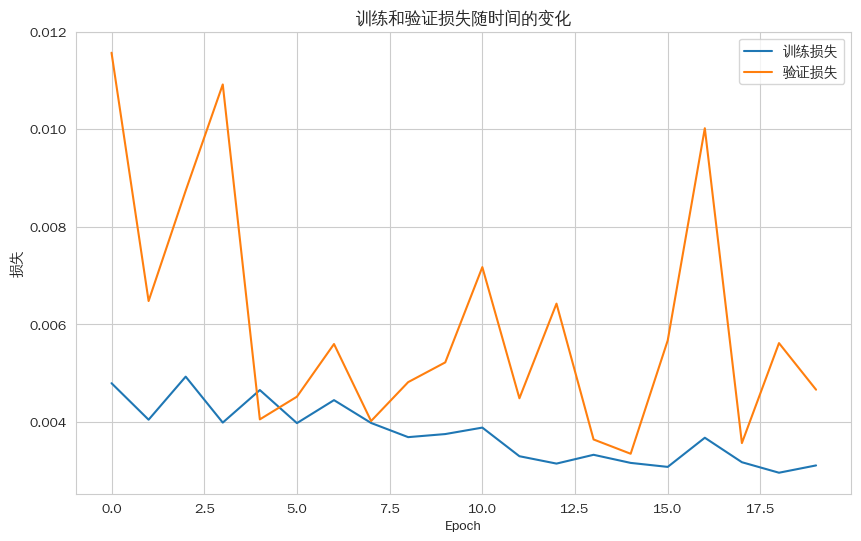

TimesFM投资组合表现指标:
年化收益率: 21.62%
年化波动率: 33.70%
夏普比率: 0.64


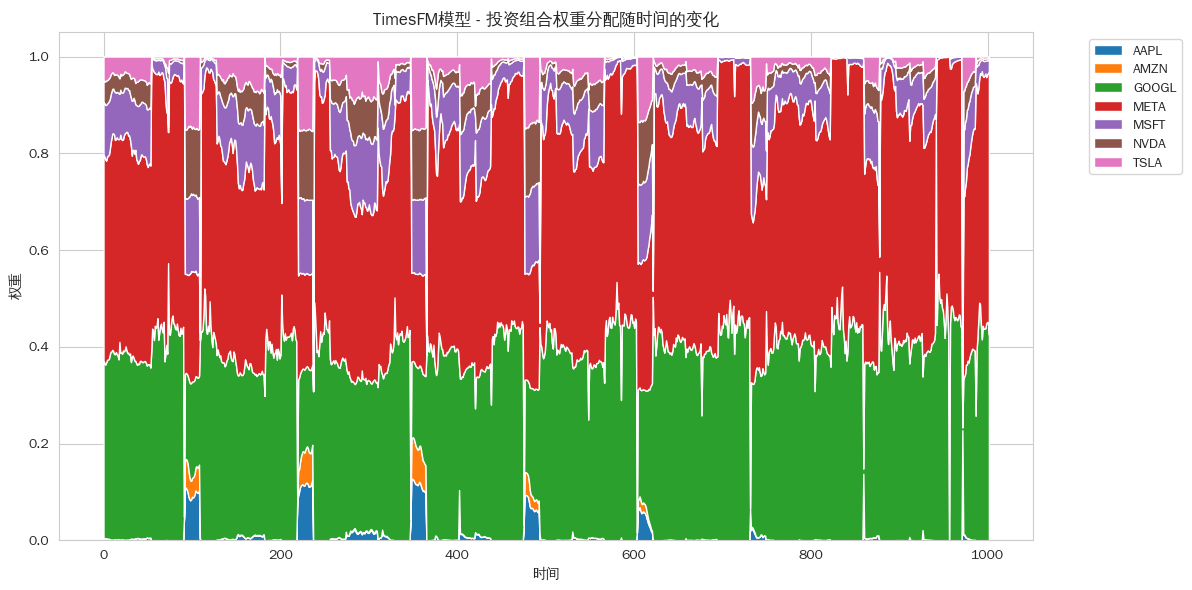

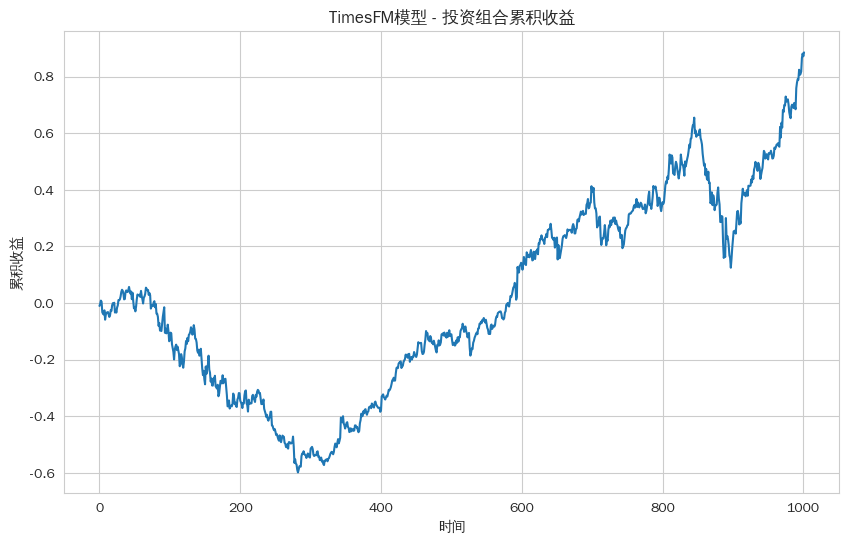

In [11]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.title('训练和验证损失随时间的变化')
plt.legend()
plt.grid(True)
plt.show()

# 在测试集上评估模型
timesfm_portfolio_model.eval()
test_predictions = []
test_losses = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        weights = timesfm_portfolio_model(batch_X)
        loss = portfolio_loss(weights, batch_y, risk_aversion=risk_aversion)
        test_predictions.append(weights.cpu())
        test_losses.append(loss.item())

# 将预测结果转换为numpy数组
test_predictions = torch.cat(test_predictions, dim=0).numpy()

# 计算测试集上的投资组合表现
test_returns = y_test.cpu().numpy()
portfolio_returns = np.sum(test_predictions * test_returns, axis=1)

# 计算性能指标
mean_return = np.mean(portfolio_returns) * 252  # 年化收益率
std_return = np.std(portfolio_returns) * np.sqrt(252)  # 年化波动率
sharpe_ratio = mean_return / std_return  # 夏普比率

print(f"TimesFM投资组合表现指标:")
print(f"年化收益率: {mean_return:.2%}")
print(f"年化波动率: {std_return:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")

# 可视化投资组合权重分配
plt.figure(figsize=(12, 6))
plt.stackplot(range(len(test_predictions)), 
             test_predictions.T,
             labels=returns.columns)
plt.xlabel('时间')
plt.ylabel('权重')
plt.title('TimesFM模型 - 投资组合权重分配随时间的变化')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 绘制累积收益曲线
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns)
plt.xlabel('时间')
plt.ylabel('累积收益')
plt.title('TimesFM模型 - 投资组合累积收益')
plt.grid(True)
plt.show()

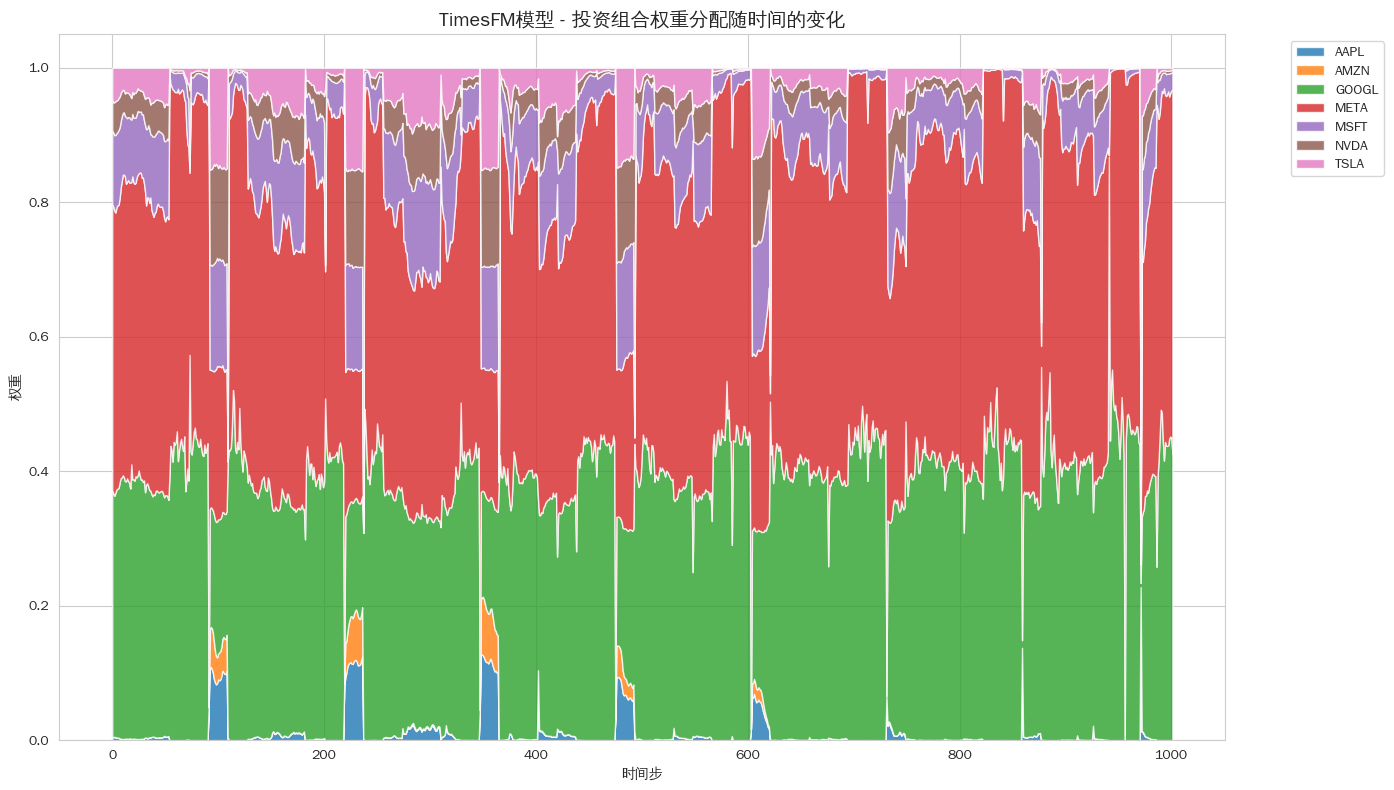

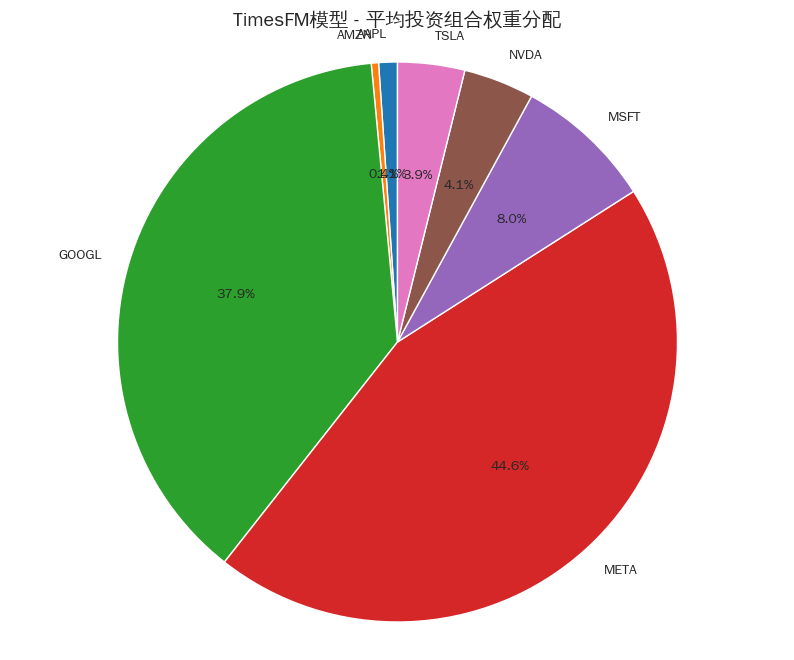

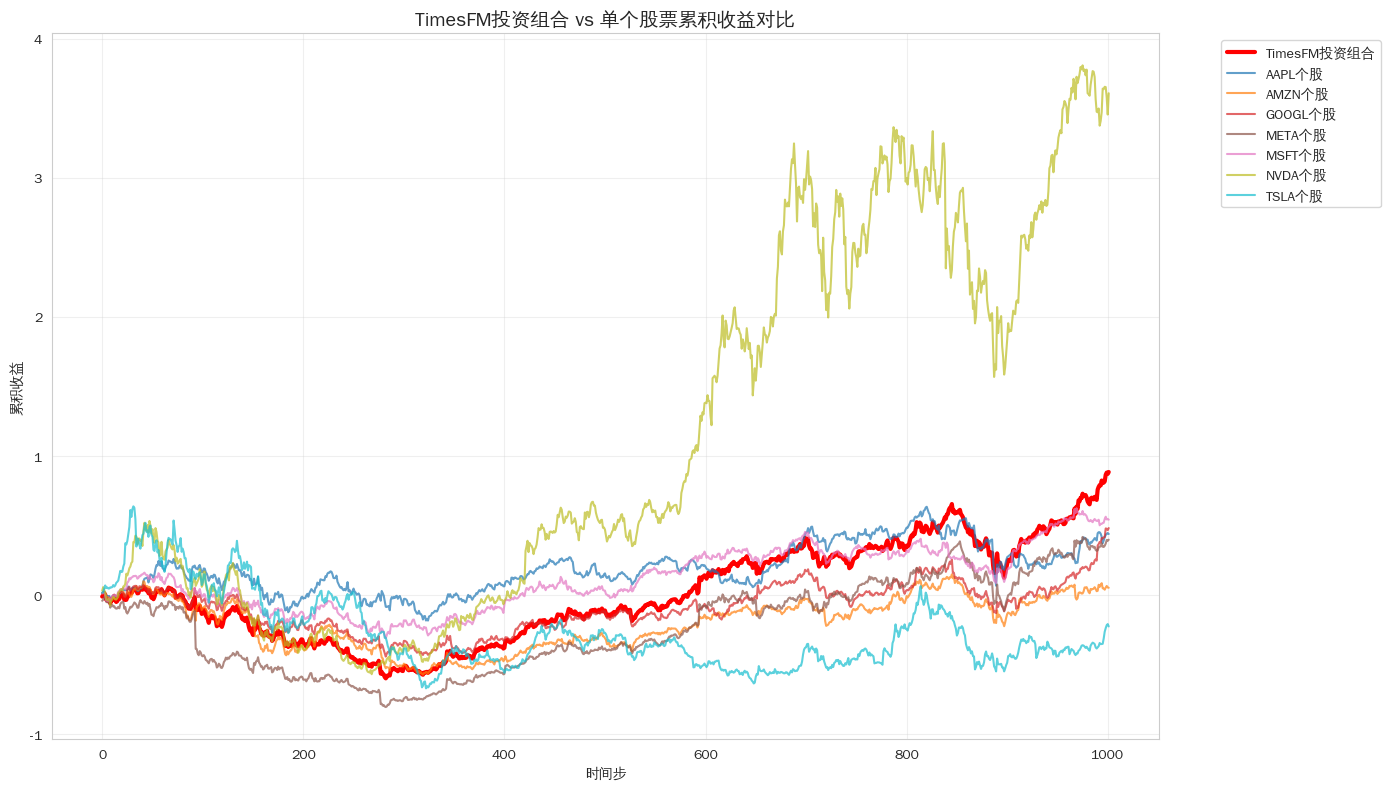

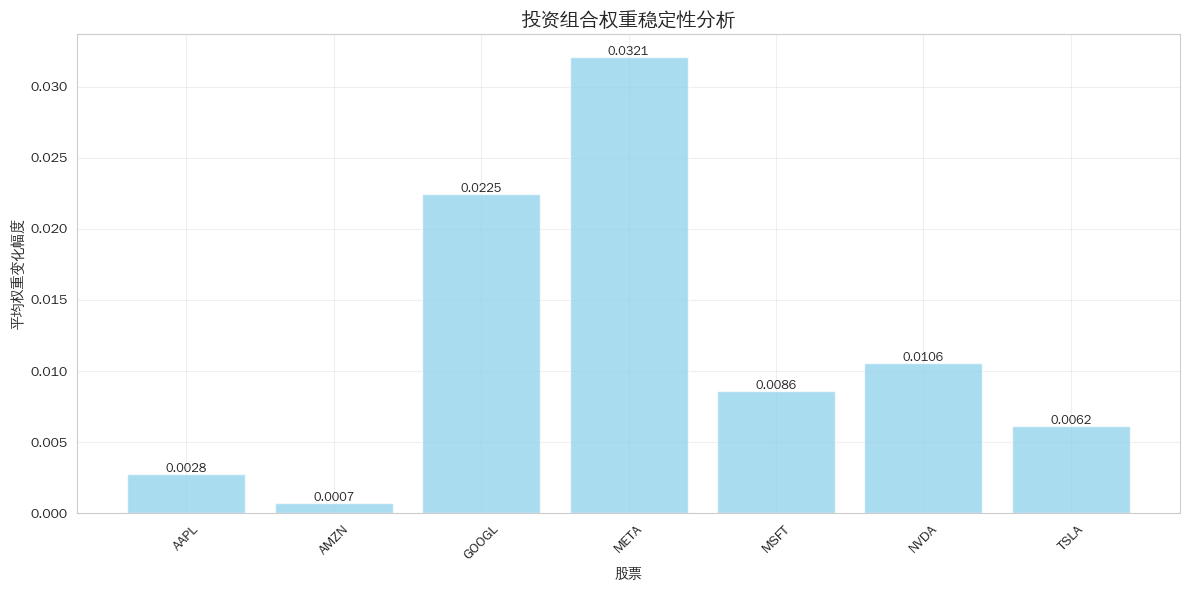

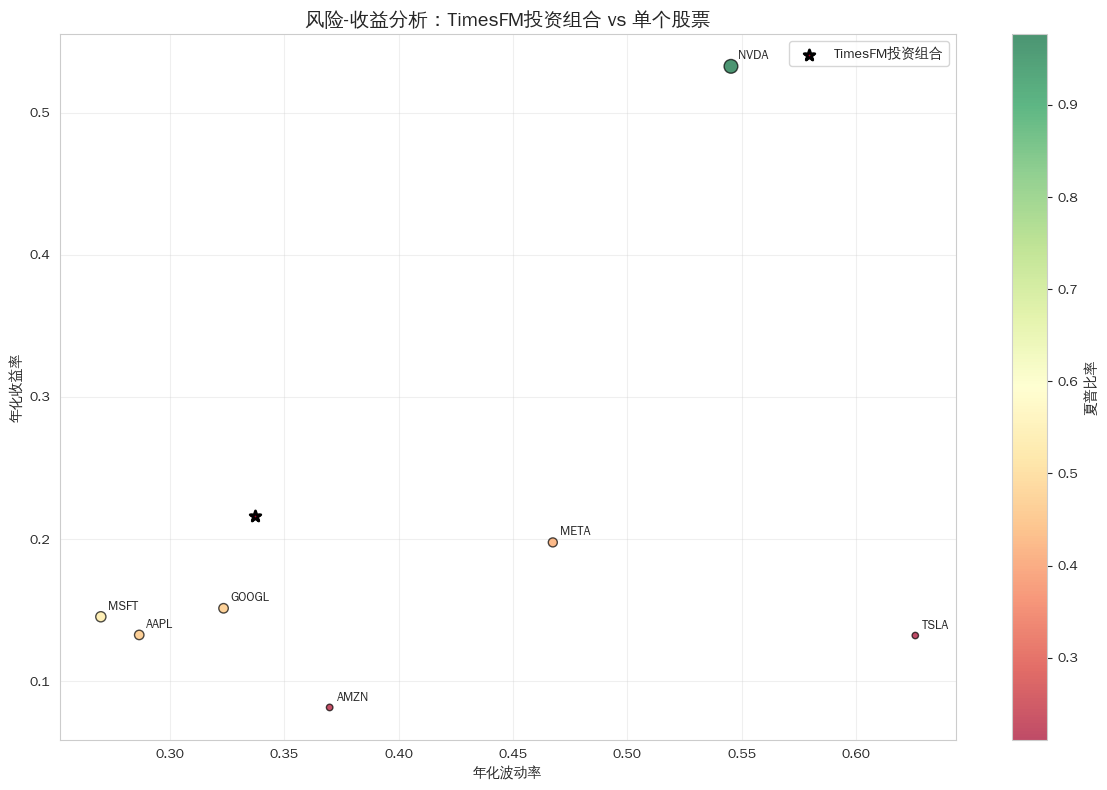

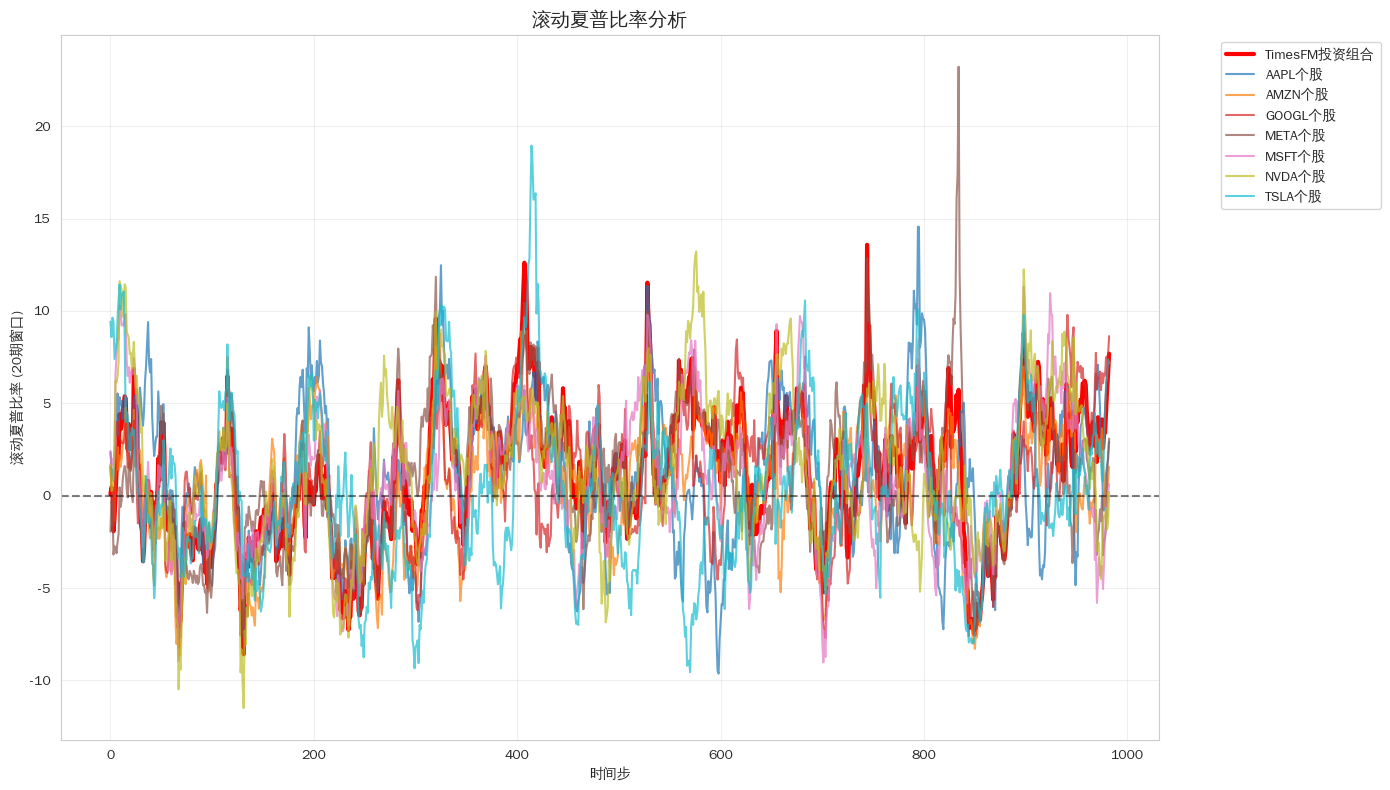

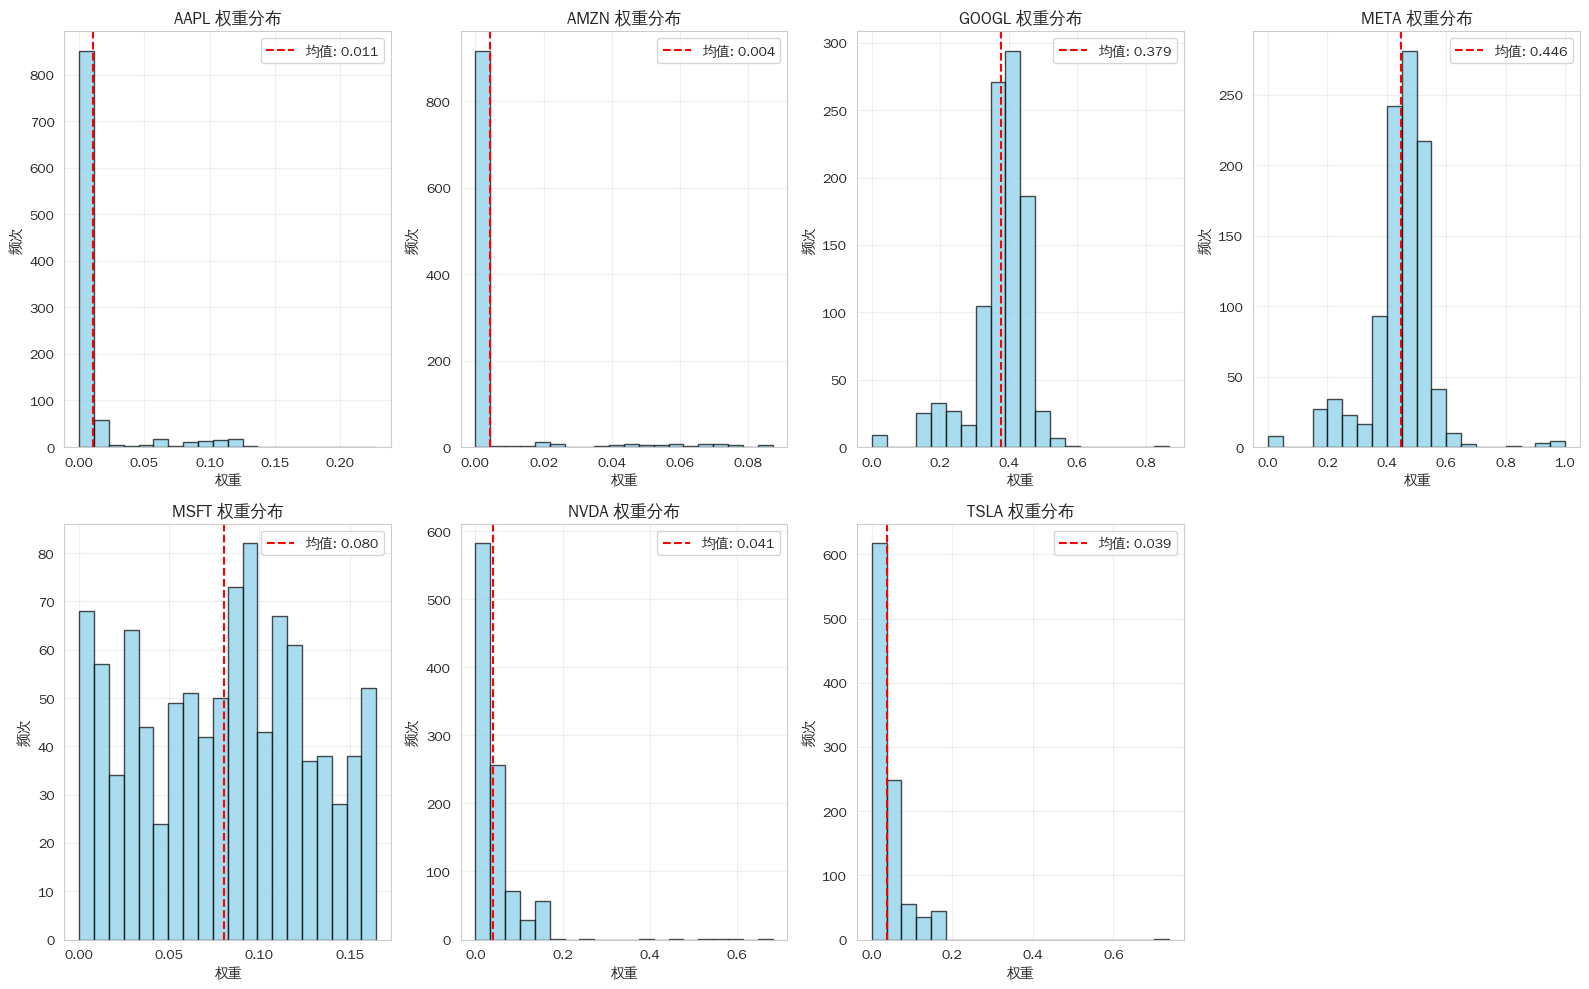


详细绩效分析汇总
资产             年化收益       年化波动       夏普比率       最大回撤       胜率
----------------------------------------------------------------------
组合          21.62%    33.70%      0.64   -62.02%   54.0%
AAPL        13.26%    28.65%      0.46   -35.18%   53.1%
AMZN         8.16%    36.98%      0.22   -61.10%   50.9%
GOOGL       15.13%    32.34%      0.47   -47.95%   53.0%
META        19.77%    46.74%      0.42   -80.24%   51.9%
MSFT        14.54%    26.97%      0.54   -40.61%   52.4%
NVDA        53.26%    54.53%      0.98   -71.87%   53.7%
TSLA        13.22%    62.59%      0.21   -79.88%   51.5%


In [12]:
# ===== 详细的可视化分析 =====

# 1. 投资组合权重分配随时间的变化
plt.figure(figsize=(14, 8))
plt.stackplot(range(len(test_predictions)),
             test_predictions.T,
             labels=returns.columns,
             alpha=0.8)
plt.xlabel('时间步')
plt.ylabel('权重')
plt.title('TimesFM模型 - 投资组合权重分配随时间的变化', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# 2. 平均权重分配饼图
avg_weights = np.mean(test_predictions, axis=0)
plt.figure(figsize=(10, 8))
plt.pie(avg_weights, labels=returns.columns, autopct='%1.1f%%', startangle=90)
plt.title('TimesFM模型 - 平均投资组合权重分配', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

# 3. 累积收益曲线对比（投资组合 vs 单个股票）
cumulative_portfolio = np.cumprod(1 + portfolio_returns) - 1
cumulative_individual = np.cumprod(1 + test_returns, axis=0) - 1

plt.figure(figsize=(14, 8))
plt.plot(cumulative_portfolio, label='TimesFM投资组合', linewidth=3, color='red')

colors = plt.cm.tab10(np.linspace(0, 1, len(returns.columns)))
for i, col in enumerate(returns.columns):
    plt.plot(cumulative_individual[:, i], label=f'{col}个股',
             linewidth=1.5, alpha=0.7, color=colors[i])

plt.xlabel('时间步')
plt.ylabel('累积收益')
plt.title('TimesFM投资组合 vs 单个股票累积收益对比', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 权重稳定性分析 - 相邻时间步的权重变化
weight_changes = np.abs(np.diff(test_predictions, axis=0))
avg_weight_changes = np.mean(weight_changes, axis=0)

plt.figure(figsize=(12, 6))
bars = plt.bar(returns.columns, avg_weight_changes, color='skyblue', alpha=0.7)
plt.xlabel('股票')
plt.ylabel('平均权重变化幅度')
plt.title('投资组合权重稳定性分析', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

# 添加数值标签
for bar, value in zip(bars, avg_weight_changes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{value:.4f}', ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. 风险-收益散点图
individual_returns = np.mean(test_returns, axis=0) * 252  # 年化收益率
individual_volatility = np.std(test_returns, axis=0) * np.sqrt(252)  # 年化波动率
individual_sharpe = individual_returns / individual_volatility

plt.figure(figsize=(12, 8))

# 绘制单个股票
scatter = plt.scatter(individual_volatility, individual_returns,
                     s=individual_sharpe * 100,  # 夏普比率影响点的大小
                     c=individual_sharpe, cmap='RdYlGn', alpha=0.7, edgecolors='black')

# 绘制投资组合
plt.scatter(std_return, mean_return, s=sharpe_ratio * 100,
           c=sharpe_ratio, cmap='RdYlGn', marker='*', 
           edgecolors='black', linewidth=2, label='TimesFM投资组合')

# 添加股票标签
for i, stock in enumerate(returns.columns):
    plt.annotate(stock, (individual_volatility[i], individual_returns[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('年化波动率')
plt.ylabel('年化收益率')
plt.title('风险-收益分析：TimesFM投资组合 vs 单个股票', fontsize=14, fontweight='bold')

# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('夏普比率')

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 6. 滚动夏普比率分析
def rolling_sharpe_ratio(returns, window=30):
    """计算滚动夏普比率"""
    if len(returns) < window:
        return np.array([])

    rolling_sharpe = []
    for i in range(window, len(returns) + 1):
        window_returns = returns[i-window:i]
        mean_ret = np.mean(window_returns)
        std_ret = np.std(window_returns)
        sharpe = mean_ret / std_ret if std_ret > 0 else 0
        rolling_sharpe.append(sharpe * np.sqrt(252))  # 年化

    return np.array(rolling_sharpe)

# 计算滚动夏普比率
portfolio_rolling_sharpe = rolling_sharpe_ratio(portfolio_returns, window=20)
individual_rolling_sharpe = np.array([rolling_sharpe_ratio(test_returns[:, i], window=20)
                                    for i in range(len(returns.columns))])

plt.figure(figsize=(14, 8))
plt.plot(portfolio_rolling_sharpe, label='TimesFM投资组合', linewidth=3, color='red')

colors = plt.cm.tab10(np.linspace(0, 1, len(returns.columns)))
for i, col in enumerate(returns.columns):
    if len(individual_rolling_sharpe[i]) > 0:
        plt.plot(individual_rolling_sharpe[i], label=f'{col}个股',
                 linewidth=1.5, alpha=0.7, color=colors[i])

plt.xlabel('时间步')
plt.ylabel('滚动夏普比率 (20期窗口)')
plt.title('滚动夏普比率分析', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 7. 权重分布直方图
plt.figure(figsize=(16, 10))

for i, col in enumerate(returns.columns):
    plt.subplot(2, 4, i+1)
    plt.hist(test_predictions[:, i], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(test_predictions[:, i]), color='red', linestyle='--',
                label=f'均值: {np.mean(test_predictions[:, i]):.3f}')
    plt.title(f'{col} 权重分布')
    plt.xlabel('权重')
    plt.ylabel('频次')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. 绩效指标汇总表
print("\n" + "="*60)
print("详细绩效分析汇总")
print("="*60)

# 计算最大回撤
def calculate_max_drawdown(returns):
    cumulative = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return np.min(drawdown)

portfolio_max_dd = calculate_max_drawdown(portfolio_returns)
individual_max_dd = [calculate_max_drawdown(test_returns[:, i]) for i in range(len(returns.columns))]

# 计算胜率
def calculate_win_rate(returns):
    return np.mean(returns > 0)

portfolio_win_rate = calculate_win_rate(portfolio_returns)
individual_win_rate = [calculate_win_rate(test_returns[:, i]) for i in range(len(returns.columns))]

# 汇总表格
print(f"{'资产':<8} {'年化收益':>10} {'年化波动':>10} {'夏普比率':>10} {'最大回撤':>10} {'胜率':>8}")
print("-" * 70)

# 投资组合
print(f"{'组合':<8} {mean_return:>9.2%} {std_return:>9.2%} {sharpe_ratio:>9.2f} {portfolio_max_dd:>9.2%} {portfolio_win_rate:>7.1%}")

# 单个股票
for i, col in enumerate(returns.columns):
    print(f"{col:<8} {individual_returns[i]:>9.2%} {individual_volatility[i]:>9.2%} {individual_sharpe[i]:>9.2f} {individual_max_dd[i]:>9.2%} {individual_win_rate[i]:>7.1%}")

print("="*60)

## 结果分析

我们可以通过以下几个方面分析TimesFM模型的性能：

1. 与基准策略（如等权重策略）的对比
2. 投资组合权重的稳定性
3. 交易成本考虑
4. 风险调整后的收益表现

性能对比（TimesFM vs 等权重）:
----------------------------------------
             指标      TimesFM          等权重
----------------------------------------
          年化收益率       21.62%       19.62%
          年化波动率       33.70%       31.82%
           夏普比率         0.64         0.62


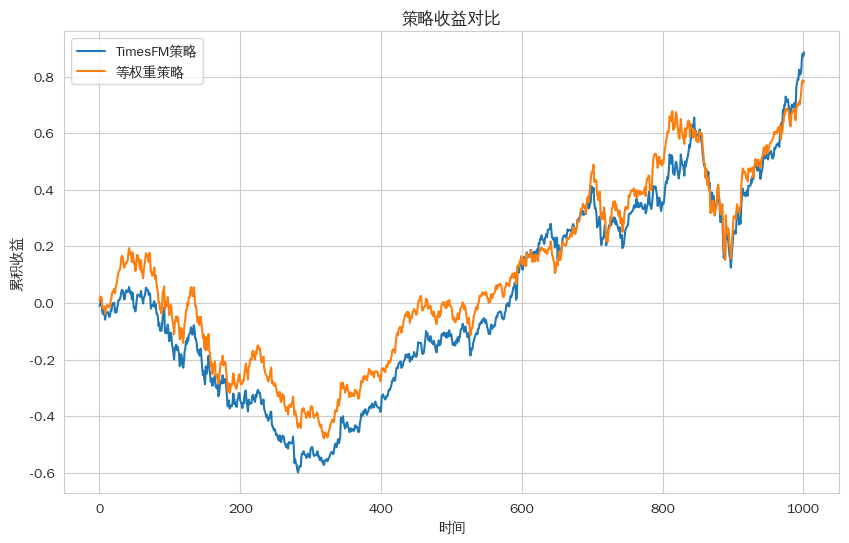


换手率分析:
TimesFM策略换手率: 0.0834
等权重策略换手率: 0.0000

权重集中度分析 (Herfindahl指数):
TimesFM策略集中度: 0.3787
等权重策略集中度: 0.1429


In [13]:
# 计算等权重策略的表现
equal_weights = np.ones((len(test_returns), len(returns.columns))) / len(returns.columns)
equal_weight_returns = np.sum(equal_weights * test_returns, axis=1)

# 计算等权重策略的指标
ew_mean_return = np.mean(equal_weight_returns) * 252
ew_std_return = np.std(equal_weight_returns) * np.sqrt(252)
ew_sharpe_ratio = ew_mean_return / ew_std_return

# 计算等权重策略的累积收益
ew_cumulative_returns = np.cumprod(1 + equal_weight_returns) - 1

# 比较性能指标
print("性能对比（TimesFM vs 等权重）:")
print("-" * 40)
print(f"{'指标':>15} {'TimesFM':>12} {'等权重':>12}")
print("-" * 40)
print(f"{'年化收益率':>15} {mean_return:>12.2%} {ew_mean_return:>12.2%}")
print(f"{'年化波动率':>15} {std_return:>12.2%} {ew_std_return:>12.2%}")
print(f"{'夏普比率':>15} {sharpe_ratio:>12.2f} {ew_sharpe_ratio:>12.2f}")

# 绘制累积收益对比
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='TimesFM策略')
plt.plot(ew_cumulative_returns, label='等权重策略')
plt.xlabel('时间')
plt.ylabel('累积收益')
plt.title('策略收益对比')
plt.legend()
plt.grid(True)
plt.show()

# 计算换手率
def calculate_turnover(weights):
    """计算每期的换手率"""
    turnover = np.abs(np.diff(weights, axis=0)).sum(axis=1).mean()
    return turnover

timesfm_turnover = calculate_turnover(test_predictions)
equal_weight_turnover = calculate_turnover(equal_weights)

print("\n换手率分析:")
print(f"TimesFM策略换手率: {timesfm_turnover:.4f}")
print(f"等权重策略换手率: {equal_weight_turnover:.4f}")

# 分析权重集中度
def calculate_herfindahl(weights):
    """计算Herfindahl指数（权重集中度）"""
    return np.mean(np.sum(weights**2, axis=1))

timesfm_concentration = calculate_herfindahl(test_predictions)
equal_weight_concentration = calculate_herfindahl(equal_weights)

print("\n权重集中度分析 (Herfindahl指数):")
print(f"TimesFM策略集中度: {timesfm_concentration:.4f}")
print(f"等权重策略集中度: {equal_weight_concentration:.4f}")